# Probabilidad de retrazo de vuelos desde Santiago de Chile

En este notebook encontramos el pipeline de entrenamiento para un modelo para la predicción de la probabilidad de atrazo de vuelos desde Santiago de Chile.

Las librerías necesarias para correr este código se encuentran en el archivo requirements.txt en root folder del proyecto y fue creado usando la librería **pipreqs**.

Para instalar las librerías es necesario correr el siguiente comando desde la terminal:

**pip install -r requirements.txt**
    
    
**Nota: el jupyter de Juan no corrió en mi ordenador, posiblemente por problemas de versión de librerías. Sin embargo, este jupyter notebook toma los avances principales de su trabajo**

## Librerías

In [1]:
# imports

# intern
from datetime import datetime
import os
from pathlib import Path
from pprint import pprint

# extern
from imblearn.over_sampling import RandomOverSampler
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay, f1_score,  make_scorer, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import swifter
import tqdm
import xgboost as xgb



## Variables Globales y seteo jupyter notebook

In [2]:
# path del repositorio
root_path = Path(os.getcwd()).parent
root_path

# set the max columns to none
pd.set_option('display.max_columns', None)

# seed para la aleatoridad
seed = 123

## 0. Datos y limpieza

In [3]:
# Datos de entrada

df = pd.read_csv(os.path.join(root_path, "datos", "dataset_SCL.csv"),  low_memory=False)

df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [4]:
# Tipo de datos y valores nulos
pd.concat([
            # Cantidad de nulos
            df.isna().sum().to_frame().rename(columns={0:'N_nulos'}), 
            # DataType
           df.dtypes.to_frame().rename(columns={0:'DataType'})
], axis=1)

,N_nulos,DataType
Fecha-I,0,object
Vlo-I,0,object
Ori-I,0,object
Des-I,0,object
Emp-I,0,object
Fecha-O,0,object
Vlo-O,1,object
Ori-O,0,object
Des-O,0,object
Emp-O,0,object


**Como solo hay una columna con un solo valor nulo, eliminamos del dataset**

In [5]:
print(df.shape)
df = df.dropna()
print(df.shape)


(68206, 18)
(68205, 18)


## 1. Preprocesamiento y creación del target

Esta parte es copia del trabajo de Juan

### 1.1 Synthetic features:
    - Temporada alta
    - Periodo del día

In [6]:
def temporada_alta(fecha):
    fecha_año = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    range1_min = datetime.strptime('15-Dec', '%d-%b').replace(year = fecha_año)
    range1_max = datetime.strptime('31-Dec', '%d-%b').replace(year = fecha_año)
    range2_min = datetime.strptime('1-Jan', '%d-%b').replace(year = fecha_año)
    range2_max = datetime.strptime('3-Mar', '%d-%b').replace(year = fecha_año)
    range3_min = datetime.strptime('15-Jul', '%d-%b').replace(year = fecha_año)
    range3_max = datetime.strptime('31-Jul', '%d-%b').replace(year = fecha_año)
    range4_min = datetime.strptime('11-Sep', '%d-%b').replace(year = fecha_año)
    range4_max = datetime.strptime('30-Sep', '%d-%b').replace(year = fecha_año)
    
    if ((fecha >= range1_min and fecha <= range1_max) or 
        (fecha >= range2_min and fecha <= range2_max) or 
        (fecha >= range3_min and fecha <= range3_max) or
        (fecha >= range4_min and fecha <= range4_max)):
        return 1
    else:
        return 0

In [7]:
df['temporada_alta'] = df['Fecha-I'].swifter.apply(temporada_alta)
df['temporada_alta'].value_counts()

Pandas Apply:   0%|          | 0/68205 [00:00<?, ?it/s]

0    46174
1    22031
Name: temporada_alta, dtype: int64

In [8]:
def get_periodo_dia(fecha):
    """
    periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I.
    """
    
    fecha_time = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S').time()
    mañana_min = datetime.strptime("05:00", '%H:%M').time()
    mañana_max = datetime.strptime("11:59", '%H:%M').time()
    tarde_min = datetime.strptime("12:00", '%H:%M').time()
    tarde_max = datetime.strptime("18:59", '%H:%M').time()
    noche_min1 = datetime.strptime("19:00", '%H:%M').time()
    noche_max1 = datetime.strptime("23:59", '%H:%M').time()
    noche_min2 = datetime.strptime("00:00", '%H:%M').time()
    noche_max2 = datetime.strptime("4:59", '%H:%M').time()
    
    if(fecha_time >= mañana_min and fecha_time <= mañana_max):
        return 'mañana'
    elif(fecha_time >= tarde_min and fecha_time <= tarde_max):
        return 'tarde'
    elif((fecha_time >= noche_min1 and fecha_time <= noche_max1) or
         (fecha_time >= noche_min2 and fecha_time <= noche_max2)):
        return 'noche'

In [9]:
df['periodo_dia'] = df['Fecha-I'].swifter.apply(get_periodo_dia)

Pandas Apply:   0%|          | 0/68205 [00:00<?, ?it/s]

In [10]:
synthetic_features_path = os.path.join(root_path, "Datos", "features", 'synthetic_features.csv')
df[['temporada_alta','periodo_dia']].to_csv(synthetic_features_path, index = False)

### 1.2 Target
La variable target es si el vuelo sufrió o no atraso, definido como atraso si el vuelo aterrizó al menos 15 minutos target

In [11]:
def dif_min(data):
    """
    atraso_15 : 1 si dif_min > 15, 0 si no.
    """
    
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    dif_min = ((fecha_o - fecha_i).total_seconds())/60
    return dif_min

In [12]:
df['dif_min'] = df.swifter.apply(dif_min, axis = 1)
df['atraso_15'] = np.where(df['dif_min'] > 15, 1, 0)

pd.concat([df['atraso_15'].value_counts().to_frame().rename(columns={0:'N'}),
           (df['atraso_15'].value_counts()/df['atraso_15'].value_counts().sum()).to_frame().rename(columns={0:'PCT'})
          ], axis=1)

df = df.drop("dif_min", axis=1)

Pandas Apply:   0%|          | 0/68205 [00:00<?, ?it/s]

In [13]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,periodo_dia,atraso_15
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,noche,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,noche,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1,noche,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,noche,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,noche,0


### 1.3 Selección de features y target

In [14]:
# Features
numeric_features = ["DIA", "MES"]
categoric_features = ["temporada_alta", "TIPOVUELO", "OPERA", "SIGLADES", "DIANOM", "periodo_dia"] 

features_cols = numeric_features + categoric_features
# Target
target_col = "atraso_15"


# matriz de features
X = df[features_cols]

# vector de target
y = df[target_col]

### 1.4 Train Test Split
- Dado que tenemos varias variables categóricas, realizamos un train test split stratificado. Para realizar eso, revisamos la cantidad de categorias por variable

#### 1.4.1 Cantidad de categorías por variable

In [15]:
count_cats_df = X[categoric_features].value_counts()
count_cats_1_df = count_cats_df[count_cats_df==1]

count_cats_1_df


temporada_alta  TIPOVUELO  OPERA        SIGLADES          DIANOM     periodo_dia
0               I          Grupo LATAM  Auckland N.Z.     Viernes    tarde          1
                                        Asuncion          Viernes    noche          1
                N          Sky Airline  Punta Arenas      Miercoles  noche          1
                I          Grupo LATAM  Florianapolis     Sabado     noche          1
                N          Sky Airline  La Serena         Martes     noche          1
                                                                                   ..
1               N          Grupo LATAM  Copiapo           Miercoles  noche          1
0               N          Grupo LATAM  Temuco            Jueves     noche          1
1               I          Grupo LATAM  Cataratas Iguacu  Martes     mañana         1
0               I          Grupo LATAM  Miami             Viernes    mañana         1
1               I          Grupo LATAM  Cataratas Iguacu  S

**Tenemos 173 combinaciones de variables categóricas con solo un ejemplo en el data set. Dejamos estos casos en el trainset para no perder ejemplos y para el resto de los ejemplos realizamos un split stratificado**

In [16]:
X_pre_split = X.reset_index().set_index(categoric_features)

X_train_2add = X_pre_split[X_pre_split.index.isin(count_cats_1_df.index)].reset_index().set_index("index")
X_train_2add.index.name = None

y_train_2add = y[y.index.isin(X_train_2add.index)]


X_train_2strat =  X_pre_split[~X_pre_split.index.isin(count_cats_1_df.index)].reset_index().set_index("index")
X_train_2strat.index.name = None

y_train_2strat = y[y.index.isin(X_train_2strat.index)]

X_train1, X_test, y_train1, y_test = train_test_split(X_train_2strat,
                                                    y_train_2strat,
                                                    test_size=0.33, 
                                                    stratify=X_train_2strat[categoric_features],
                                                    random_state=seed)

# agregamos los ejemplos que dejamos fuera
X_train = pd.concat([X_train1, X_train_2add])
y_train = pd.concat([y_train1, y_train_2add])

### 1.5 Transfodor de columnas

In [17]:
preprocesador = ColumnTransformer(
                                    transformers = [
                                                    ('numeric', StandardScaler(), numeric_features),
                                                    ('categoric', OneHotEncoder(), categoric_features),
                                                  ]
                                 )

## 2. Modelación
- Para la modelación recrearemos los modelos de Juan y probaremos un par más que tienen fama de tener buena performance para problemas con clases desbalanceadas. Luego seleccionaremos un modelo y realizaremos un optimización de hiper parámetros.


- Métrica de evaluación principal será el **score f-1** enfocado en la clase 1, que indica retrazo de vuelo** porque asumiremos que comercialmente crea más problemáticas predecir como "a la hora" un vuelo con retrazo. Además, tendremos como métricas secundarias el área bajo la curva **AUC** para comparar la diferencia de performance entre el trainset y el testset para ver si hay overfitting.

### 2.1 Modelo base
- Recreamos la modelación base de Juan con regresión logística

In [28]:
cls_lr = LogisticRegression()

### 2.1.1 Pipeline base
- Pipeline base en base al preprocesador y el modelo base

In [29]:
pipeline_base = Pipeline(
                        [
                            ("preprocesador", preprocesador),
                            ("clasificador", cls_lr)
                        ]
                   )

### 2.1.2 Entrenamiento base

In [30]:
modelo_base = pipeline_base.fit(X_train, y_train)

C:\Users\HP.LAPTOP-RD4IEETA\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.1.3 Evaluación modelo base

In [31]:
def evaluacion_performance(y, y_pred, cls):
    
    
    print("Reporte de clasificación:")
    print(classification_report(y, y_pred))
    
    print("Matriz de confusión")
    cm = confusion_matrix(y, y_pred, labels=cls.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cls.classes_)
    disp.plot()
    
    print("Curva ROC")
    RocCurveDisplay.from_predictions(y, y_pred)
    
    

'--- Evaluación de Performance In-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     37339
           1       0.59      0.04      0.08      8415

    accuracy                           0.82     45754
   macro avg       0.71      0.52      0.49     45754
weighted avg       0.78      0.82      0.75     45754

Matriz de confusión
Curva ROC


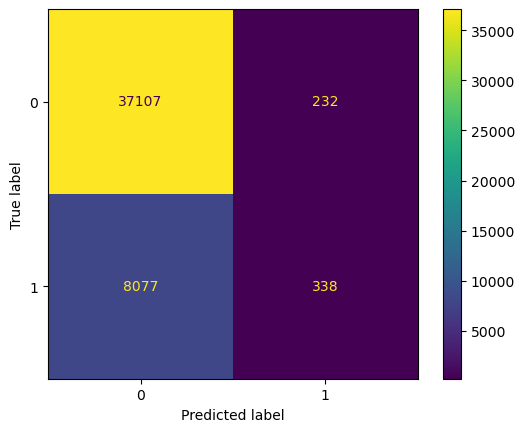

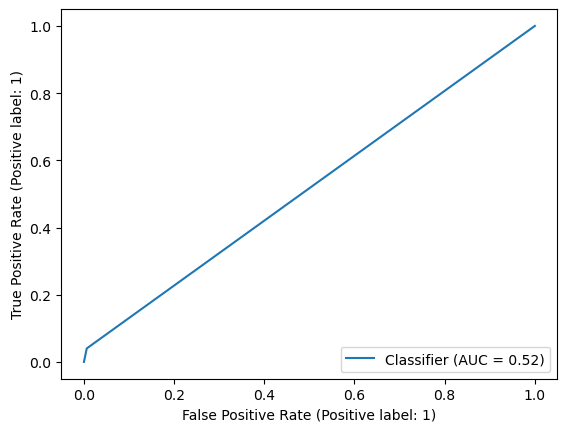

In [32]:
y_pred_train = modelo_base.predict(X_train)
display("--- Evaluación de Performance In-Sample ---")
evaluacion_performance(y_train, y_pred_train, modelo_base['clasificador'])

'--- Evaluación de Performance Out-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18252
           1       0.63      0.05      0.08      4199

    accuracy                           0.82     22451
   macro avg       0.73      0.52      0.49     22451
weighted avg       0.78      0.82      0.75     22451

Matriz de confusión
Curva ROC


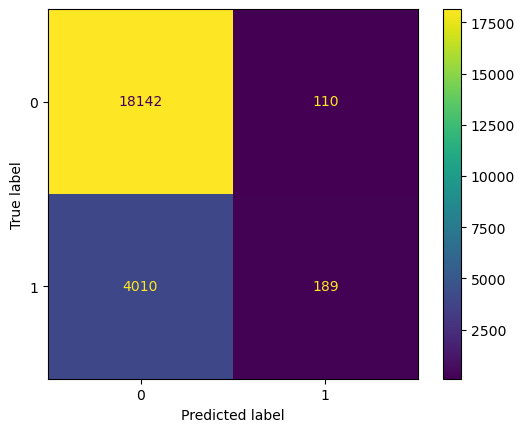

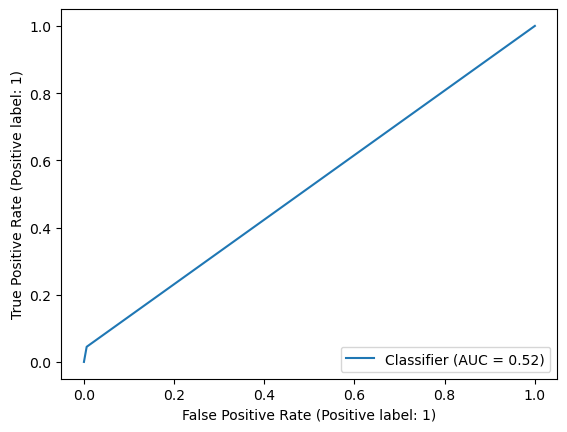

In [33]:
y_pred_test = modelo_base.predict(X_test)
display("--- Evaluación de Performance Out-Sample ---")
evaluacion_performance(y_test, y_pred_test, modelo_base['clasificador'])

In [58]:
f1_lr_train = f1_score(y_train, y_pred_train)
f1_lr_test = f1_score(y_test, y_pred_test)

f1_lr_train, f1_lr_test

(0.29313829275334424, 0.2281177381874516)

**El modelo base no posee overfitting dado que lo hace igual de mal en el test set como en el trainset. Posee un pobre f1 de 0.08 y el AUC de 0.52 muestra que el modelo no tiene la capacidad de distinguir entre las dos clases y es equivalente a un clasificador aleatorio.**

### 2.2 Modelo XGBOOST
- Recreamos la modelación con XGBOOST de Juan

In [59]:
cls_xgb = xgb.XGBClassifier(random_state=seed)

### 2.2.1 Pipeline XGBOOST
- Pipeline base en base al preprocesador y el modelo base

In [60]:
pipeline_xgb = Pipeline(
                        [
                            ("preprocesador", preprocesador),
                            ("clasificador", cls_xgb)
                        ]
                   )

### 2.2.2 Entrenamiento XGBOOST

In [61]:
modelo_xgb = pipeline_xgb.fit(X_train, y_train)

### 2.2.3 Evaluación modelo XGBOOST

'--- Evaluación de Performance In-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     37339
           1       0.77      0.18      0.29      8415

    accuracy                           0.84     45754
   macro avg       0.81      0.58      0.60     45754
weighted avg       0.83      0.84      0.80     45754

Matriz de confusión
Curva ROC


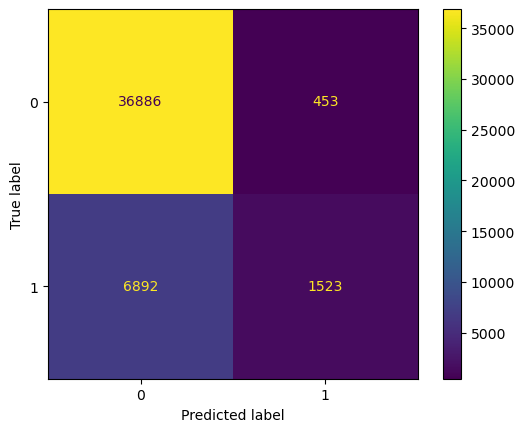

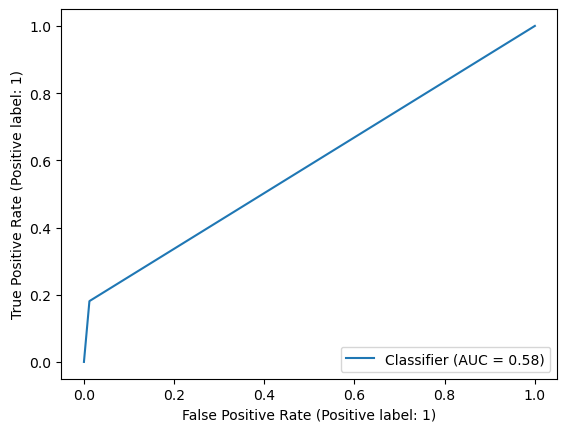

In [62]:
y_pred_train = modelo_xgb.predict(X_train)
display("--- Evaluación de Performance In-Sample ---")
evaluacion_performance(y_train, y_pred_train, modelo_xgb['clasificador'])

'--- Evaluación de Performance Out-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     18252
           1       0.61      0.14      0.23      4199

    accuracy                           0.82     22451
   macro avg       0.72      0.56      0.56     22451
weighted avg       0.79      0.82      0.77     22451

Matriz de confusión
Curva ROC


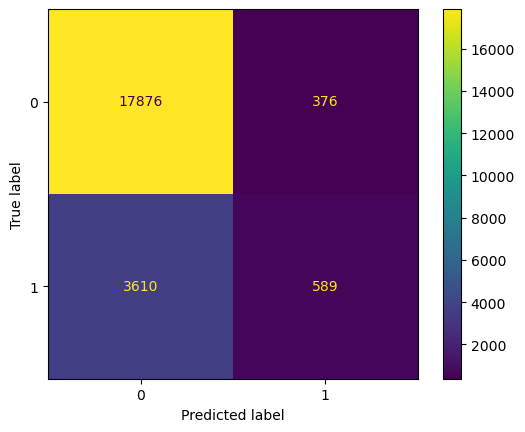

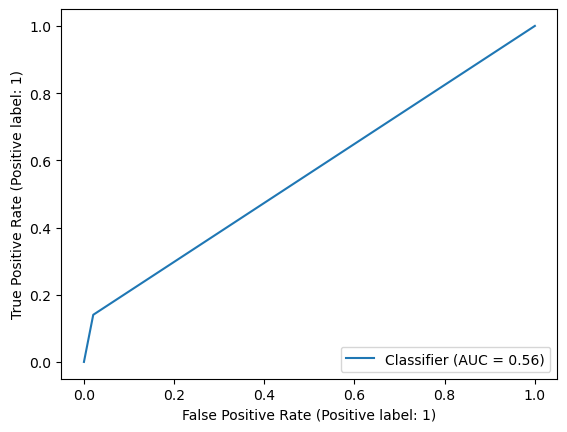

In [63]:
y_pred_test = modelo_xgb.predict(X_test)
display("--- Evaluación de Performance Out-Sample ---")
evaluacion_performance(y_test, y_pred_test, modelo_xgb['clasificador'])

In [64]:
f1_xgb_train = f1_score(y_train, y_pred_train)
f1_xgb_test = f1_score(y_test, y_pred_test)

f1_xgb_train, f1_xgb_test

(0.29313829275334424, 0.2281177381874516)

**El modelo xgboost lo hace considerablemente mejor en f1, a pesar de que el AUC se mantiene cerca a como lo haría un modelo aleatorio**


**Probaremos un par de modelos más, famosos por ser útiles en problemas con clases desbalanceadas Para ver si poseen mejor performance. Estos son RandomForest y GradientBoost***

In [65]:
def evaluar_modelo(cls_class, X_train, y_train, X_test, y_test):
    
    cls = cls_class(random_state=seed)
    
    pipeline = Pipeline(
                        [
                            ("preprocesador", preprocesador),
                            ("clasificador", cls)
                        ]
                   )
    modelo = pipeline.fit(X_train, y_train)
    
    y_pred_train = modelo.predict(X_train)
    display("--- Evaluación de Performance In-Sample ---")
    evaluacion_performance(y_train, y_pred_train, modelo['clasificador'])
    
    y_pred_test = modelo.predict(X_test)
    display("--- Evaluación de Performance Out-Sample ---")
    evaluacion_performance(y_test, y_pred_test, modelo['clasificador'])
    
    f1_cls_train = f1_score(y_train, y_pred_train)
    f1_cls_test = f1_score(y_test, y_pred_test)

    return f1_cls_train, f1_cls_test

'--- Evaluación de Performance In-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     37339
           1       0.91      0.74      0.82      8415

    accuracy                           0.94     45754
   macro avg       0.93      0.86      0.89     45754
weighted avg       0.94      0.94      0.94     45754

Matriz de confusión
Curva ROC


'--- Evaluación de Performance Out-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18252
           1       0.40      0.23      0.29      4199

    accuracy                           0.79     22451
   macro avg       0.62      0.57      0.58     22451
weighted avg       0.76      0.79      0.77     22451

Matriz de confusión
Curva ROC
0.8178901185253094 0.2909693954470074


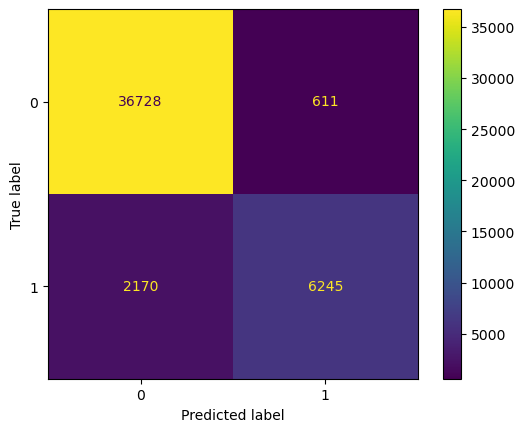

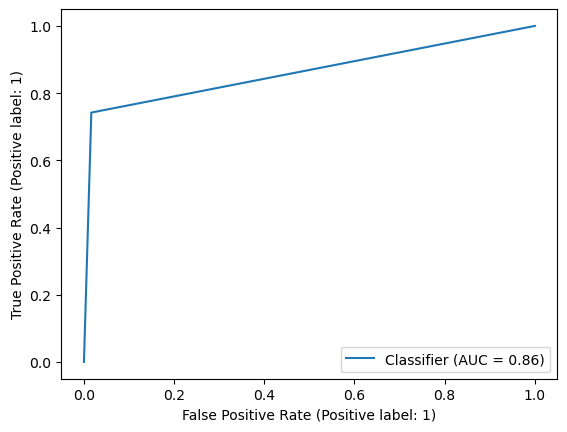

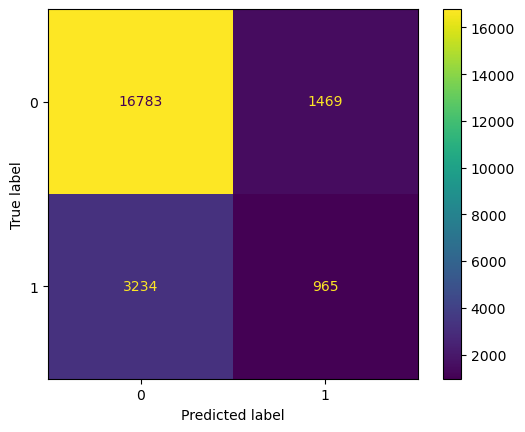

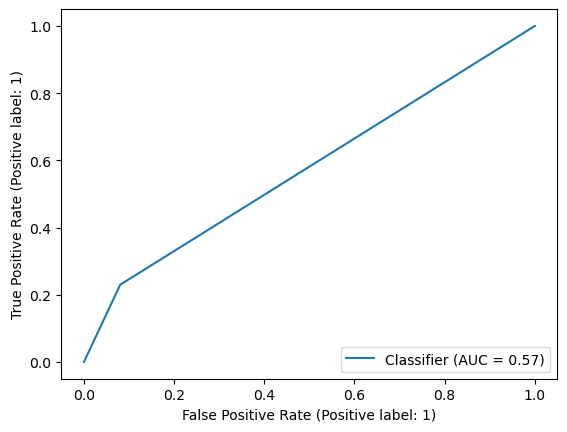

In [66]:
# Random Forest
f1_rf_train, f1_rf_test = evaluar_modelo(RandomForestClassifier, X_train, y_train, X_test, y_test)

print(f1_rf_train, f1_rf_test)

'--- Evaluación de Performance In-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     37339
           1       0.71      0.05      0.10      8415

    accuracy                           0.82     45754
   macro avg       0.77      0.52      0.50     45754
weighted avg       0.80      0.82      0.75     45754

Matriz de confusión
Curva ROC


'--- Evaluación de Performance Out-Sample ---'

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18252
           1       0.64      0.05      0.08      4199

    accuracy                           0.82     22451
   macro avg       0.73      0.52      0.49     22451
weighted avg       0.78      0.82      0.75     22451

Matriz de confusión
Curva ROC
0.09868348268613786 0.0840747330960854


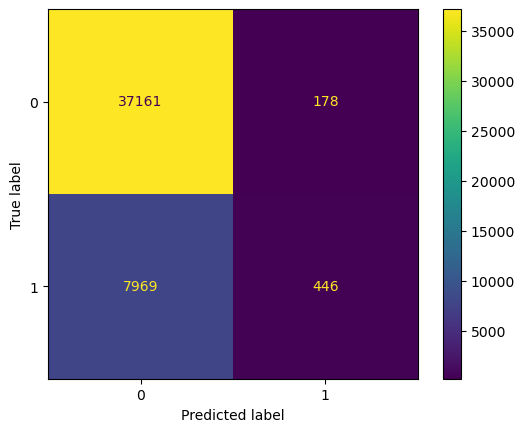

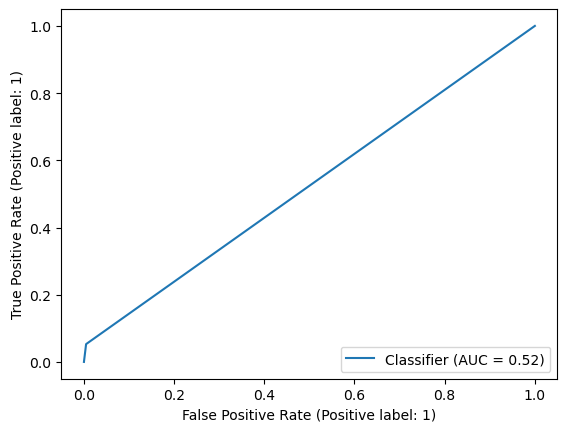

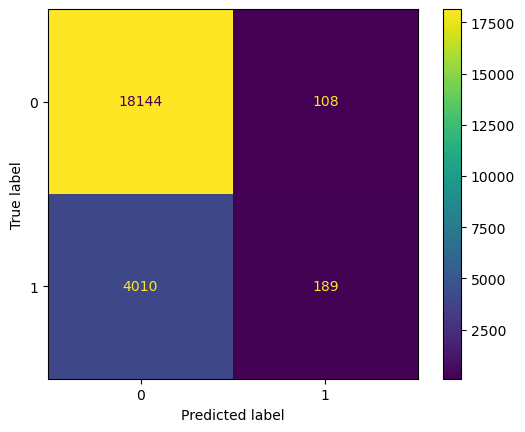

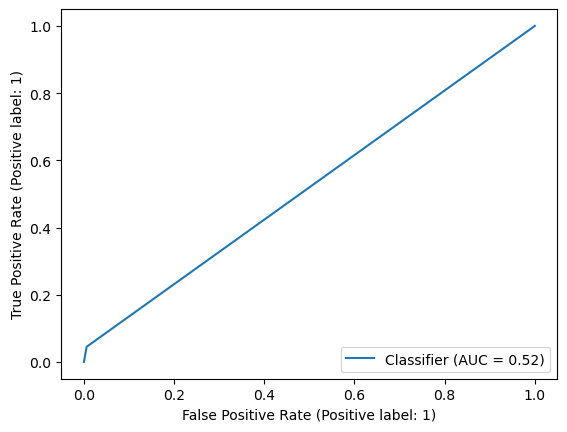

In [67]:
# Gradient Boosting
f1_gb_train, f1_gb_test = evaluar_modelo(GradientBoostingClassifier, X_train, y_train, X_test, y_test)

print(f1_gb_train, f1_gb_test)

In [68]:
print("\t\tResumen")
pd.DataFrame({"LR":[f1_lr_train, f1_lr_test], "XGB": [f1_xgb_train, f1_xgb_test],
              "RF": [f1_rf_train, f1_rf_test], "GB": [f1_gb_train, f1_gb_test]}, index=['f1-train', "f1_test"])

		Resumen


,LR,XGB,RF,GB
f1-train,0.293138,0.293138,0.817890,0.098683
f1_test,0.228118,0.228118,0.290969,0.084075


**Random Forest lo hace significativamente, respecto al score f-1 mejor en el trainset y levemente mejor en el testset respecto a xgboost. Continuaremos con este modelo y probaremos disminuir el overfitting a través de un RandomGridSearch con cross-validation**

## 3. Optimización modelo
- Se realiza una optimización del modelo RandomForest
- realizamos una estrategía de oversampling para equilibrar la cantidad de ejemplos de las clases en el trainset
- Buscamos optimizar el score f-1 de la clase 1 (atraso)
- Realizamos un RandomSearchCV para la optmización de hiper parámetros

**Disclaimer: Por temas de tiempo, no realizaremos la optimización exhaustiva, pero aquí está el código para realizarla**

In [71]:
# Aplicamos oversampling a la clase minoritaria
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Definimos una métrica personalizada que penaliza más los falsos negativos
scorer = make_scorer(f1_score, pos_label=1)

# Creaamos un modelo de Random Forest
cls_rf = RandomForestClassifier(random_state=seed, class_weight='balanced')

pipeline_rf = Pipeline(
                        [
                            ("preprocesador", preprocesador),
                            ("clasificador", cls_rf)
                        ]
                   )

# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'clasificador__n_estimators': [50, 500], #[10, 100, 1000],
    'clasificador__max_depth': [10, 100], #[10, 30, 50],
    'clasificador__min_samples_split': [2], #[2, 8],
    'clasificador__min_samples_leaf': [1], #[1, 4],
    'clasificador__bootstrap': [True]#[True, False]
}



# Realizamos una RandomizedSearchCV para optimizar hiperparámetros
random_search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_grid,
                                   scoring=scorer, cv=5, random_state=seed, n_jobs=-1, verbose=2)

random_search_rf.fit(X_train_resampled, y_train_resampled)

print(random_search_rf.best_params_)

C:\Users\HP.LAPTOP-RD4IEETA\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\HP.LAPTOP-RD4IEETA\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


{'clasificador__n_estimators': 50, 'clasificador__min_samples_split': 2, 'clasificador__min_samples_leaf': 1, 'clasificador__max_depth': 10, 'clasificador__bootstrap': True}


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.63      0.74     37339
           1       0.30      0.71      0.43      8415

    accuracy                           0.65     45754
   macro avg       0.61      0.67      0.58     45754
weighted avg       0.80      0.65      0.69     45754

Matriz de confusión
Curva ROC


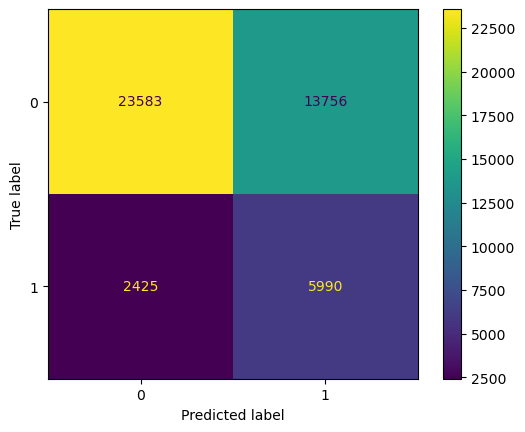

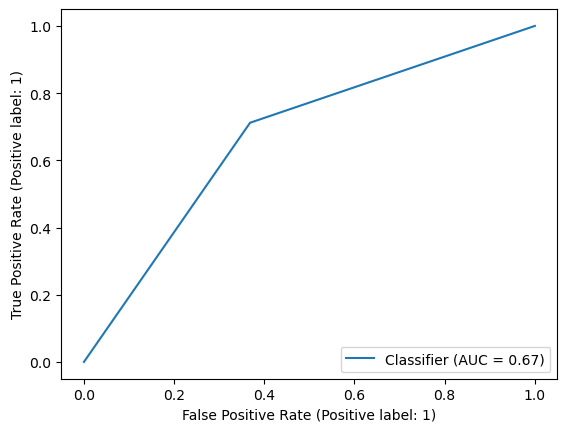

In [72]:
modelo = random_search_rf.best_estimator_

modelo.fit(X_train, y_train)

y_pred_train = modelo.predict(X_train)

evaluacion_performance(y_train, y_pred_train, modelo['clasificador'])

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73     18252
           1       0.28      0.65      0.39      4199

    accuracy                           0.62     22451
   macro avg       0.58      0.64      0.56     22451
weighted avg       0.77      0.62      0.67     22451

Matriz de confusión
Curva ROC


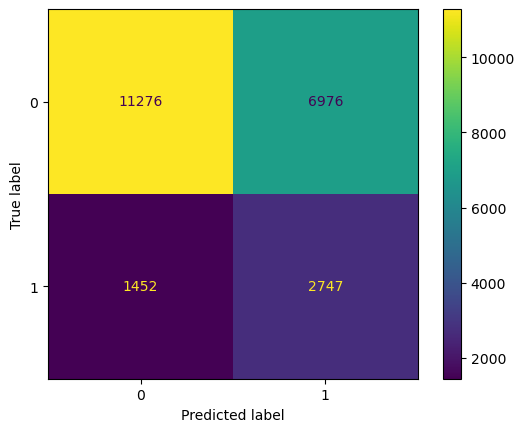

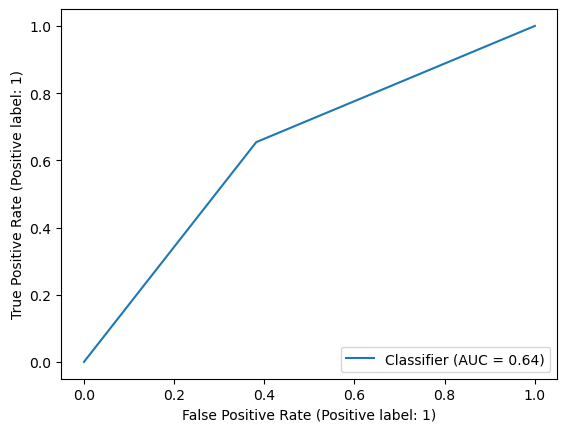

In [73]:
y_pred_test = modelo.predict(X_test)

evaluacion_performance(y_test, y_pred_test, modelo['clasificador'])

In [74]:
f1_rf_opt_train = f1_score(y_train, y_pred_train)
f1_rf_opt_test = f1_score(y_test, y_pred_test)

print("\t\tResumen")
pd.DataFrame({"LR":[f1_lr_train, f1_lr_test], "XGB": [f1_xgb_train, f1_xgb_test],
              "RF": [f1_rf_train, f1_rf_test], "GB": [f1_gb_train, f1_gb_test],
             "RF-OPT": [f1_rf_opt_train, f1_rf_opt_test]}, index=['f1-train', "f1_test"])

		Resumen


,LR,XGB,RF,GB,RF-OPT
f1-train,0.293138,0.293138,0.817890,0.098683,0.425411
f1_test,0.228118,0.228118,0.290969,0.084075,0.394627


***La optimización de hiper parámetros, a pesar de no ser exhaustiva, logra reducir el overfitting y mantiene mejor performance, en función al score f-1, respecto a los otros modelos.**

**Seguimos con el entrenamiento final del modelo optimizado, con todo el dataset y la serialización**

## 4. Entrenamiento final
Entrenamos el mejor modelo elegido por la optimización de hiperparámetros con todo el dataset

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72     55591
           1       0.29      0.71      0.41     12614

    accuracy                           0.62     68205
   macro avg       0.59      0.66      0.56     68205
weighted avg       0.79      0.62      0.66     68205

Matriz de confusión
Curva ROC


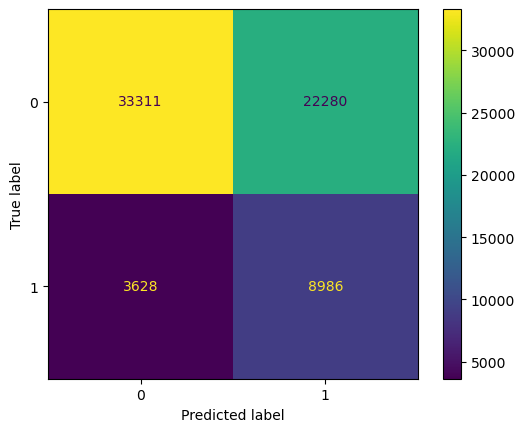

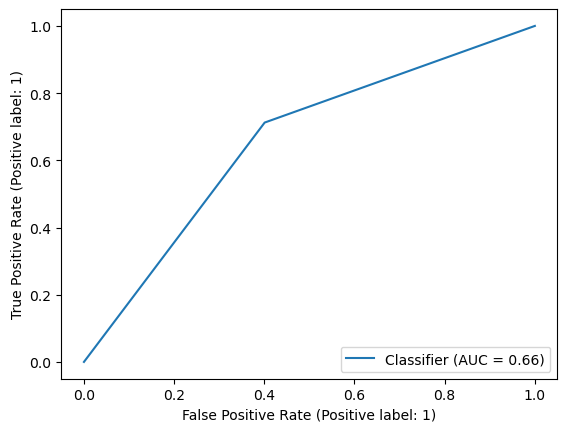

In [75]:
modelo = random_search_rf.best_estimator_

modelo.fit(X, y)

y_pred = modelo.predict(X)

evaluacion_performance(y, y_pred, modelo['clasificador'])

## 5. Serializamos el modelo

In [76]:
path_modelo = os.path.join(root_path, "modelos", "modelo_rf.pkl.gz")

joblib.dump(modelo, path_modelo, compress=('zlib', 9))

['C:\\Users\\HP\\monchi\\Challenge Machine Learning Engineer - NeuralWorks\\api-serverless-retrazo-de-vuelos-scl\\modelos\\modelo_rf.pkl.gz']

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72     55591
           1       0.29      0.71      0.41     12614

    accuracy                           0.62     68205
   macro avg       0.59      0.66      0.56     68205
weighted avg       0.79      0.62      0.66     68205

Matriz de confusión
Curva ROC


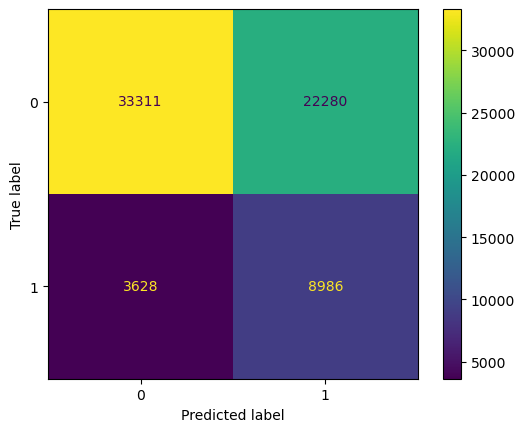

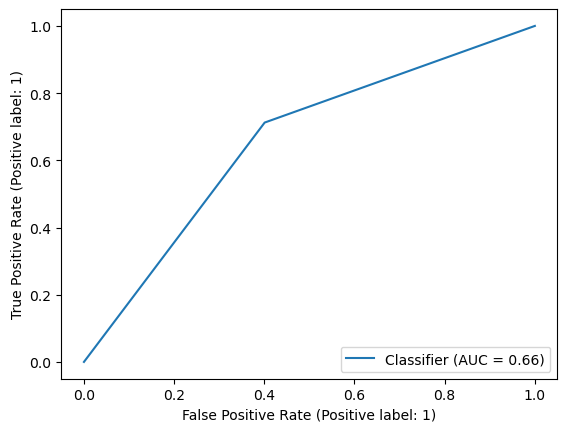

In [77]:
path_modelo = os.path.join(root_path, "modelos", "modelo_rf.pkl.gz")

# Comprobamos que se guardó bien
loaded_model = joblib.load(path_modelo)

y_pred = loaded_model.predict(X)

evaluacion_performance(y, y_pred, loaded_model['clasificador'])